In [1]:
# TensorFlow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# core libraries
import os
import glob
import numpy as np
import pandas as pd
import itertools

# basic libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the data

# Get current working directory
current_dir = os.getcwd() 

# Append data/mnist.npz to the previous path to get the full path
data_path = "/kaggle/input/rsna-breast-cancer-detection/train_images"

data_image_512_path = "/kaggle/input/rsna-breast-cancer-512-pngs"

In [3]:
breast_img = glob.glob("/kaggle/input/rsna-breast-cancer-512-pngs/*.png", recursive = True)

In [4]:
for imgname in breast_img[:3]:
    print(imgname)

/kaggle/input/rsna-breast-cancer-512-pngs/10289_1390886438.png
/kaggle/input/rsna-breast-cancer-512-pngs/21915_1598001440.png
/kaggle/input/rsna-breast-cancer-512-pngs/5123_1805049792.png


In [5]:
train_csv = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
test_csv = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/test.csv")

In [6]:
train_csv

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [7]:
test_csv

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [8]:
train_csv.columns

Index(['site_id', 'patient_id', 'image_id', 'laterality', 'view', 'age',
       'cancer', 'biopsy', 'invasive', 'BIRADS', 'implant', 'density',
       'machine_id', 'difficult_negative_case'],
      dtype='object')

In [9]:
train_csv.cancer.value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

In [10]:
patients_count = len(set(train_csv.patient_id))
print(f"patients count: {patients_count}")

patients count: 11913


<AxesSubplot:>

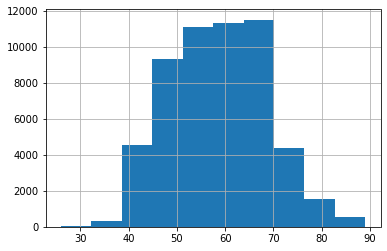

In [11]:
train_csv.age.hist()

In [12]:
train_csv.laterality.value_counts()

R    27439
L    27267
Name: laterality, dtype: int64

In [13]:
# Create the path to each image in train_csv.
for i in range(len(train_csv)):
    train_csv.loc[i, 'path'] = os.path.join(data_image_512_path + '/' + str(train_csv.loc[i, 'patient_id']) + '_' + str(train_csv.loc[i, 'image_id']) + '.png')

train_csv.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/1000...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/1000...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/1000...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/1000...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-512-pngs/1001...


In [14]:
train_subset_0 = train_csv[train_csv.cancer == 0]
train_subset_1 = train_csv[train_csv.cancer == 1]

print(train_subset_0.shape, train_subset_1.shape)
print(train_subset_0.laterality.value_counts())
print(train_subset_1.laterality.value_counts())

(53548, 15) (1158, 15)
R    26869
L    26679
Name: laterality, dtype: int64
L    588
R    570
Name: laterality, dtype: int64


In [15]:
# take a random sample of 8 rows for each subset 0 and 1 to plot the images associated with them 
sampled_rows_subset_0 = train_subset_0.sample(n=8) # random_state=42
sampled_rows_subset_1 = train_subset_1.sample(n=8) # random_state=42

In [16]:
sampled_rows_subset_0

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
17712,1,28706,1097076486,R,CC,59.0,0,0,0,1.0,0,A,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/2870...
48504,1,62256,2103034074,R,MLO,59.0,0,0,0,1.0,0,A,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/6225...
4667,2,15032,137106149,L,CC,76.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/1503...
43467,1,56831,1565896203,R,CC,73.0,0,0,0,NaN,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/5683...
25511,2,37278,1531256216,L,CC,76.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/3727...
20612,2,31862,1886113040,R,CC,63.0,0,0,0,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/3186...
24062,2,35703,534087486,L,MLO,60.0,0,0,0,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/3570...
7285,1,17752,2129134142,L,MLO,65.0,0,0,0,1.0,1,C,170,False,/kaggle/input/rsna-breast-cancer-512-pngs/1775...


In [17]:
sampled_rows_subset_1

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
32446,2,44780,244481933,R,CC,66.0,1,1,1,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/4478...
41124,1,54463,385806898,L,MLO,59.0,1,1,0,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/5446...
25798,2,37573,1344523058,L,MLO,66.0,1,1,1,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-512-pngs/3757...
54351,1,9559,1047452753,L,MLO,76.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/9559...
407,2,10432,458553546,L,CC,65.0,1,1,1,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/1043...
41125,1,54463,1345167254,L,CC,59.0,1,1,0,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/5446...
27535,1,39401,253372914,R,MLO,54.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/3940...
33630,2,46090,1469951993,L,CC,59.0,1,1,1,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/4609...


In [18]:
random_images_0 = []
random_images_1 = []

# save 8 random images path from subset_0 in arr random_images_0
for index, row in sampled_rows_subset_0.iterrows():
    image_path = row["path"] # data_image_512_path + "/" + str(row["patient_id"]) + "_" + str(row["image_id"]) + ".png"
    random_images_0.append(image_path)
    
# save 8 random images path from subset_1 in arr random_images_1
for index, row in sampled_rows_subset_1.iterrows():
    image_path = row["path"]
    random_images_1.append(image_path)

In [19]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def plot_8_images_0_and_1_in_grid(images_path_0, images_path_1):
    plt.figure(figsize = (20, 20))

    s = 0
    for image_path in images_path_0:

            img = load_img(image_path, target_size=(512, 512))
            img = img_to_array(img)

            plt.subplot(4, 4, 2*s+1)
            plt.axis('off')
            plt.title('no cancer')
            plt.imshow(img.astype('uint8'))
            s += 1

    s = 1
    for image_path in images_path_1:

            img = load_img(image_path, target_size=(512, 512))
            img = img_to_array(img)
            plt.subplot(4, 4, 2*s)
            plt.axis('off')        
            plt.title('cancer')
            plt.imshow(img.astype('uint8'))
            s += 1

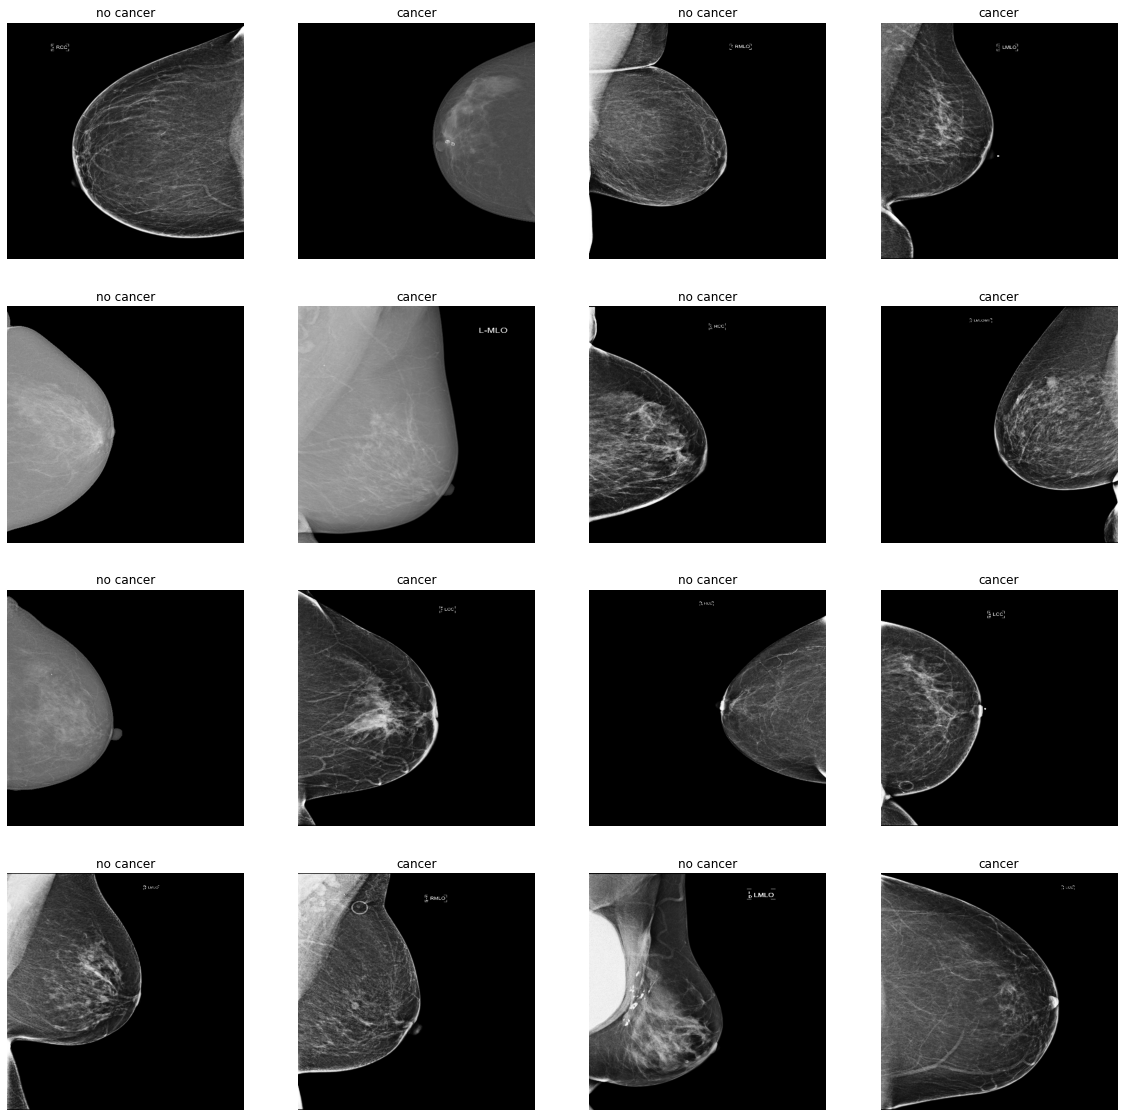

In [20]:
plot_8_images_0_and_1_in_grid(random_images_0, random_images_1)

In [21]:
count_0 =  train_subset_0.cancer.value_counts()
print(count_0)

0    53548
Name: cancer, dtype: int64


In [22]:
#### making oversampling to balance 0's and 1'

train_subset_1 = train_subset_1.sample(n=53548, replace=True)

# Concatenate the subsets
train_subset_main = pd.concat([train_subset_0, train_subset_1])

In [23]:
train_subset_main

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/1000...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/1000...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/1000...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/1000...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-512-pngs/1001...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53081,2,8248,1228024526,L,MLO,52.0,1,1,0,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-512-pngs/8248...
28586,2,40496,1462467771,R,MLO,67.0,1,1,0,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/4049...
46906,2,60442,787281164,L,MLO,52.0,1,1,1,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/6044...
24669,2,36420,141266182,R,CC,53.0,1,1,1,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/3642...


In [24]:
train_subset_main.laterality.value_counts()

L    54007
R    53089
Name: laterality, dtype: int64

In [25]:
train_subset_main.shape

(107096, 15)

In [26]:
# train_csv if we want to train all datatset without oversampling
# but we are using train_subset_main to train the model on dataset that is balanced 
# between 0's an 1's for cancer

train_df, val_df = train_test_split(train_subset_main,  
                                   test_size = 0.20, 
                                   random_state = 2018)

print('train', train_df.shape[0], 'validation', val_df.shape[0])
print('train', train_df['cancer'].value_counts())
print('validation', val_df['cancer'].value_counts())

train 85676 validation 21420
train 0    42967
1    42709
Name: cancer, dtype: int64
validation 1    10839
0    10581
Name: cancer, dtype: int64


In [27]:
train_df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
34747,1,47280,1058632970,L,CC,65.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/4728...
10276,2,21055,1150801606,L,CC,55.0,0,0,0,0.0,0,NaN,48,True,/kaggle/input/rsna-breast-cancer-512-pngs/2105...
41514,2,54860,1135670090,R,CC,58.0,0,0,0,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-512-pngs/5486...
21400,1,32735,605081290,L,CC,61.0,0,0,0,0.0,0,A,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/3273...
4334,1,14706,1060299310,L,MLO,70.0,1,1,0,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/1470...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10606,2,21414,236076976,R,MLO,69.0,0,0,0,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/2141...
40954,1,54271,1648214016,R,CC,51.0,0,0,0,2.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/5427...
6162,1,16694,138126676,R,CC,56.0,1,1,1,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/1669...
14201,2,25178,1215035771,L,MLO,56.0,1,1,1,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/2517...


In [28]:
val_df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
9447,2,20106,2133480049,L,MLO,61.0,0,0,0,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/2010...
4046,2,14327,917935711,R,MLO,52.0,1,1,1,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/1432...
2118,2,12264,484935123,R,MLO,55.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/1226...
23969,2,35577,1684172985,R,CC,52.0,0,0,0,0.0,0,NaN,29,True,/kaggle/input/rsna-breast-cancer-512-pngs/3557...
49007,1,62889,584051752,R,CC,60.0,0,0,0,NaN,0,A,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/6288...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51091,1,65077,545603591,R,MLO,74.0,1,1,0,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/6507...
22179,1,33583,326653717,R,MLO,60.0,1,1,0,0.0,0,C,170,False,/kaggle/input/rsna-breast-cancer-512-pngs/3358...
23377,1,34957,401386563,L,MLO,46.0,0,0,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/3495...
42244,1,55603,1923296699,L,MLO,63.0,0,0,0,1.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/5560...


In [29]:
import shutil

# Define the destination directory for train with 2 classes 0 'normal' and 1 'cancer'.
train_dir = '/kaggle/working/train'

# Create the train directory (with sub dir 0 and 1) if it doesn't exist.
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
    os.makedirs(train_dir + "/0")
    os.makedirs(train_dir + "/1")
  
    
# Copy the images to the train directory.
i = 0
for _, row in train_df.iterrows():
    destination_path = os.path.join(train_dir + "/" + str(row["cancer"]) + "/" + str(row["patient_id"]) + "_" + str(row["image_id"]) + "_" + str(i) + ".png")
    shutil.copy2(row["path"], destination_path)
    i += 1

In [30]:
# Define the destination directory for validation with 2 classes 0 'normal' and 1 'cancer'.
val_dir = '/kaggle/working/val'

# Create the validation directory (with sub dir 0 and 1) if it doesn't exist.
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
    os.makedirs(val_dir + "/0")
    os.makedirs(val_dir + "/1")
  
    
# Copy the images to the val directory.
i = 0
for _, row in val_df.iterrows():
    destination_path = os.path.join(val_dir + "/" + str(row["cancer"]) + "/" + str(row["patient_id"]) + "_" + str(row["image_id"]) + "_" + str(i) + ".png")
    shutil.copy2(row["path"], destination_path)
    i += 1

In [31]:
import random

def get_8_random_images_path_for_each_0_and_1(from_train = True):
    image_dir = train_dir if from_train else val_dir
    
    non_cancer_imgs_path = glob.glob(f"{image_dir}/0/*.png", recursive = True)
    cancer_imgs_path = glob.glob(f"{image_dir}/1/*.png", recursive = True)
    
    # return 8 random images from the list of file paths for both type
    return random.sample(non_cancer_imgs_path, k=8), random.sample(cancer_imgs_path, k=8)

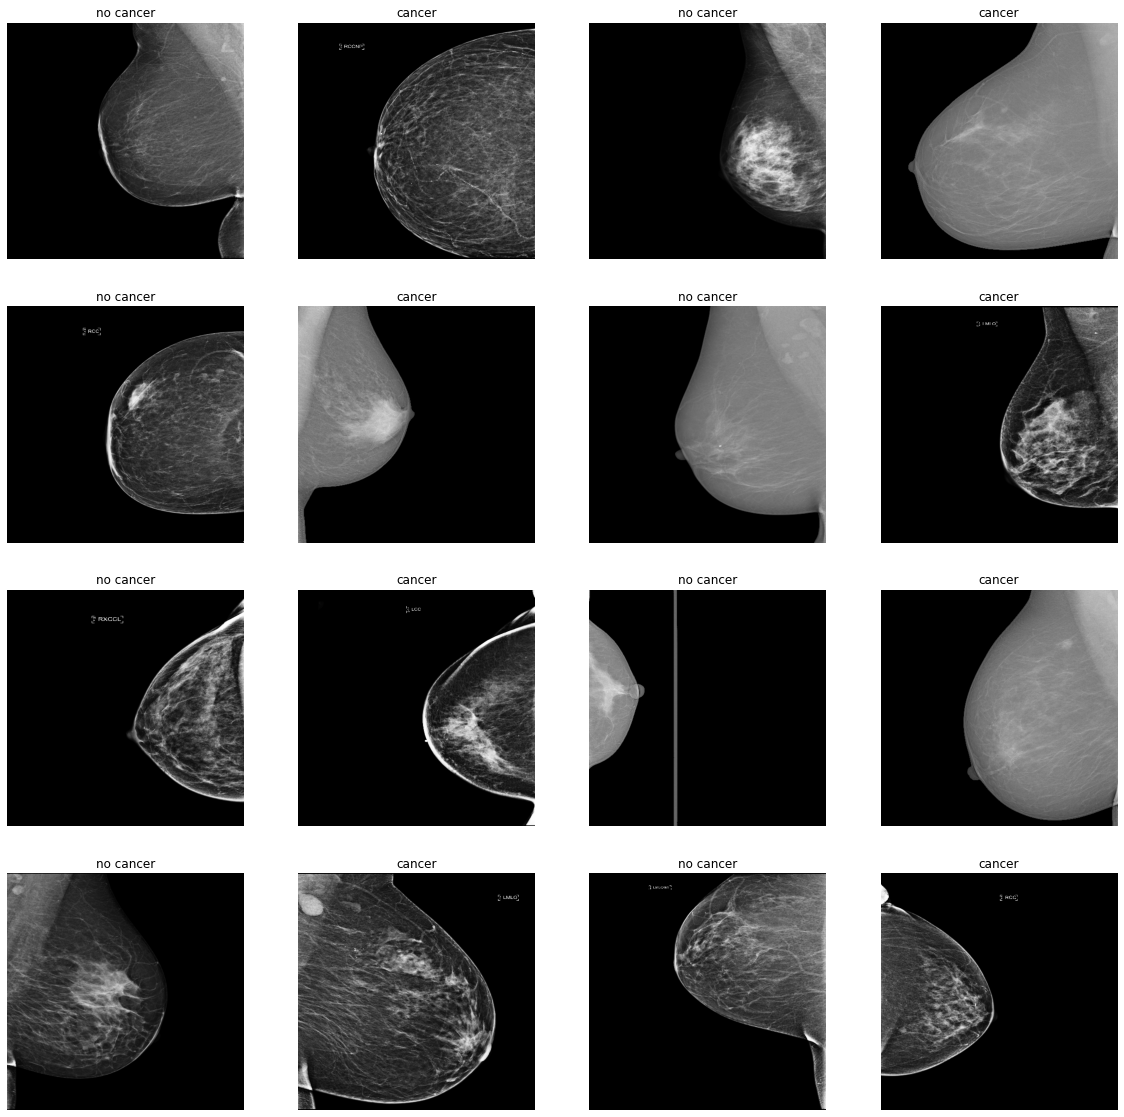

In [32]:
# Plotting 16 images from train dir (8 for each class)

random_images_0, random_images_1 = get_8_random_images_path_for_each_0_and_1(from_train = True)

plot_8_images_0_and_1_in_grid(random_images_0, random_images_1)

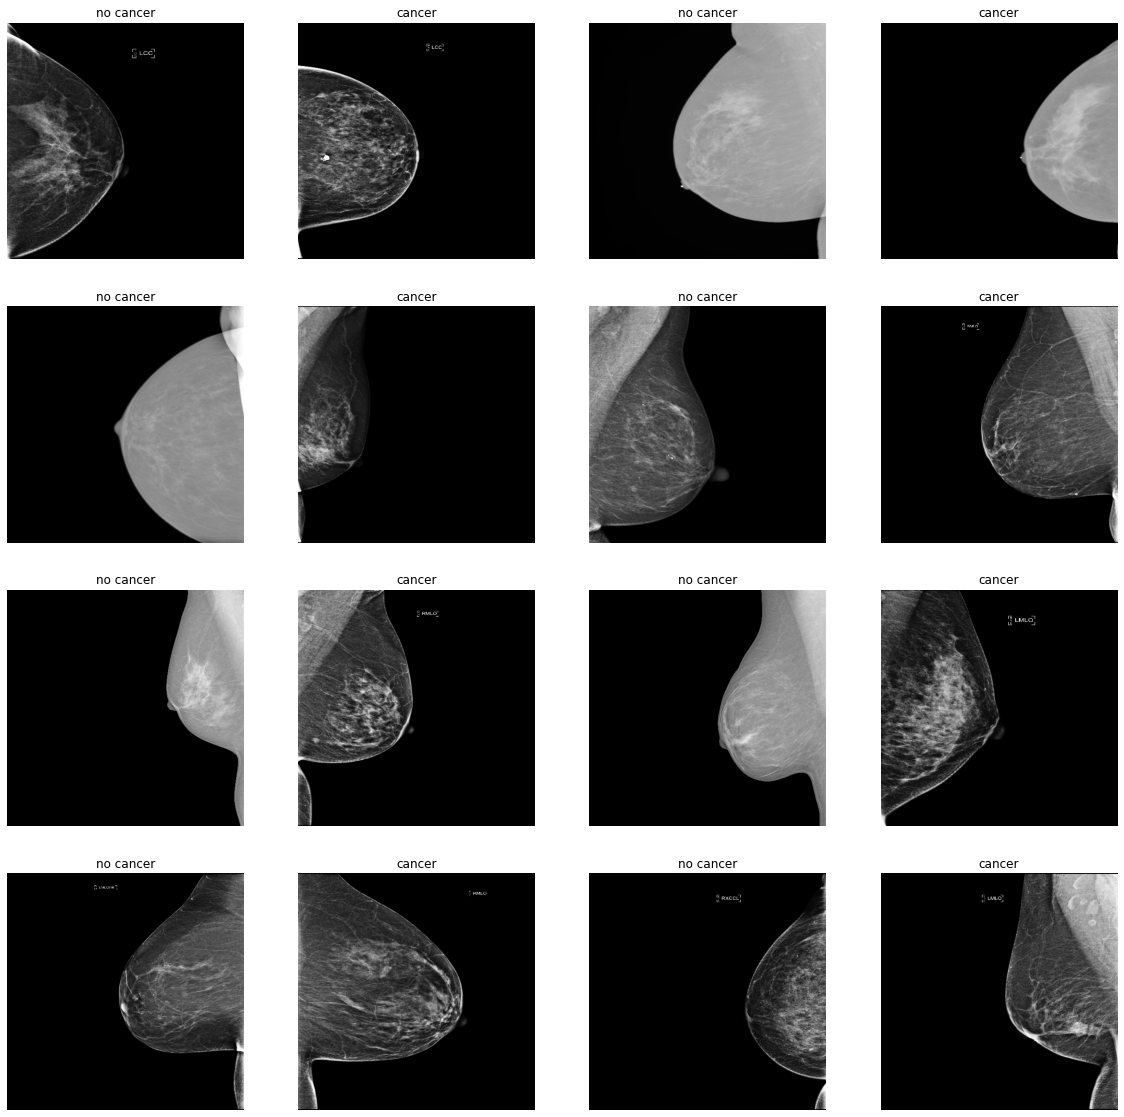

In [33]:
# Plotting 16 images from val dir (8 for each class)

random_images_0, random_images_1 = get_8_random_images_path_for_each_0_and_1(from_train = False)

plot_8_images_0_and_1_in_grid(random_images_0, random_images_1)

In [34]:
train_datagen = ImageDataGenerator(rescale = 1./255.)
val_datagen = ImageDataGenerator(rescale = 1./255.,)

In [35]:
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (512, 512),
    batch_size = 10,
    classes=['0', '1'],
    shuffle=True,
    seed=42
)
validation_generator = val_datagen.flow_from_directory(
        val_path,
        target_size = (512, 512),
        batch_size = 10,
        classes=['0', '1'],
        shuffle=False,
        seed=42
)

Found 85676 images belonging to 2 classes.
Found 21420 images belonging to 2 classes.


In [36]:
basic_model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(512,512,3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  #layers.Dense(128, activation='relu'),
  layers.Dense(2, activation='softmax')
])

basic_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0

In [37]:
basic_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [38]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the method that checks the accuracy at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') >= 0.995:
            print("\nReached 99.5% accuracy so cancelling training!") 
            # Stop training once the above condition is met
            self.model.stop_training = True

In [39]:
basic_model_history = basic_model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = len(train_generator),
    epochs = 15
)

Epoch 1/15
8568/8568 [==============================] - 840s 97ms/step - loss: 0.3941 - accuracy: 0.7916 - val_loss: 0.0529 - val_accuracy: 0.9846
Epoch 2/15
8568/8568 [==============================] - 831s 97ms/step - loss: 0.0285 - accuracy: 0.9914 - val_loss: 0.0409 - val_accuracy: 0.9890
Epoch 3/15
8568/8568 [==============================] - 826s 96ms/step - loss: 0.0156 - accuracy: 0.9957 - val_loss: 0.0347 - val_accuracy: 0.9923
Epoch 4/15
8568/8568 [==============================] - 827s 96ms/step - loss: 0.0147 - accuracy: 0.9964 - val_loss: 0.0765 - val_accuracy: 0.9870
Epoch 5/15
8568/8568 [==============================] - 845s 99ms/step - loss: 0.0132 - accuracy: 0.9969 - val_loss: 0.0293 - val_accuracy: 0.9936
Epoch 6/15
8568/8568 [==============================] - 845s 99ms/step - loss: 0.0101 - accuracy: 0.9979 - val_loss: 0.0607 - val_accuracy: 0.9922
Epoch 7/15
8568/8568 [==============================] - 850s 99ms/step - loss: 0.0141 - accuracy: 0.9976 - val_loss: 0

In [40]:
basic_model.evaluate(validation_generator)

2142/2142 [==============================] - 140s 66ms/step - loss: 0.0950 - accuracy: 0.9951


[0.09503517299890518, 0.9950980544090271]

In [41]:
def plot_history(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [43]:
def print_accuracy(confusion_matrix):
    correct_predictions = 0
    for i in range(len(confusion_matrix)):
        correct_predictions += confusion_matrix[i][i]

    print(f"accuracy = {correct_predictions/confusion_matrix.sum()*100}%")

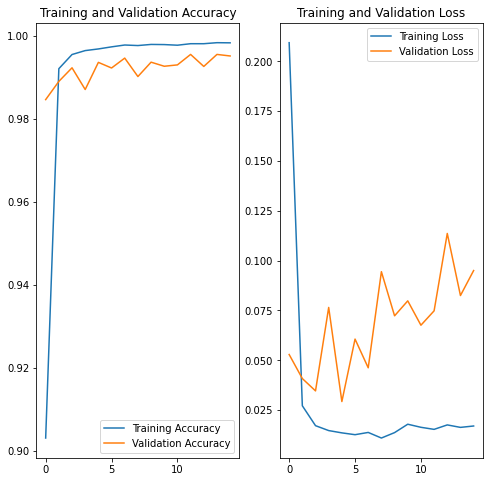

In [44]:
plot_history(history=basic_model_history, epochs=15)

In [45]:
validation_generator.reset()

In [46]:
basic_model_predictions = basic_model.predict(validation_generator)
basic_model_predictions

array([[1.000000e+00, 0.000000e+00],
       [1.000000e+00, 1.529697e-34],
       [1.000000e+00, 0.000000e+00],
       ...,
       [0.000000e+00, 1.000000e+00],
       [0.000000e+00, 1.000000e+00],
       [0.000000e+00, 1.000000e+00]], dtype=float32)

In [47]:
y_pred_basic_model = np.argmax(basic_model_predictions, axis=-1)
y_pred_basic_model

array([0, 0, 0, ..., 1, 1, 1])

In [48]:
y_true = validation_generator.classes
y_true

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [49]:
basic_model_cm = confusion_matrix(y_true=y_true, y_pred=y_pred_basic_model)

Confusion matrix, without normalization
[[10476   105]
 [    0 10839]]


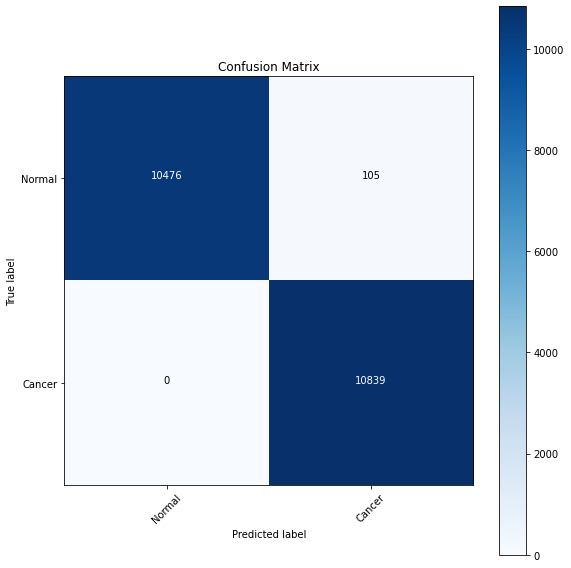

In [50]:
plot_confusion_matrix(cm=basic_model_cm, classes=['Normal','Cancer'], title='Confusion Matrix')

In [51]:
print_accuracy(basic_model_cm)

accuracy = 99.50980392156863%


In [52]:
# for f1 score
print(classification_report(y_true, y_pred_basic_model))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     10581
           1       0.99      1.00      1.00     10839

    accuracy                           1.00     21420
   macro avg       1.00      1.00      1.00     21420
weighted avg       1.00      1.00      1.00     21420



In [53]:
basic_model.save("/kaggle/working/model.h5")

In [ ]:
from PIL import Image
import numpy as np
from skimage import transform

def load(filename):
   image = Image.open(filename)
   np_image = np.array(image).astype('float32')/255
   np_image = transform.resize(np_image, (512, 512, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image